Importing

In [62]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

Load in VGG16 (features)
VGG16 is split into two portions:

vgg16.features, which are all the convolutional and pooling layers
vgg16.classifier, which are the three linear, classifier layers at the end
We only need the features portion, which we're going to load in and "freeze" the weights of, below.

In [63]:
# get the "features" portion of VGG16 (we will not need the "classifier" portion)
vgg = models.vgg1(pretrained=True).features

# freeze all VGG parameters since we're on\ly optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load in Content and Style Images
You can load in any images you want! Below, we've provided a helper function for loading in any type and size of image. The load_image function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squash the content and style images so that they are of the same size

In [65]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''

    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

 helper function for un-normalizing an image and converting it from a Tensor image to a NumPy image for display


In [66]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [67]:
# load in content and style image
content = load_image('/kaggle/input/artistic-neural-style-transfer-using-pytorch/call-of-duty-ghosts.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/kaggle/input/artistic-neural-style-transfer-using-pytorch/starrynight.jpg', shape=content.shape[-2:]).to(device)

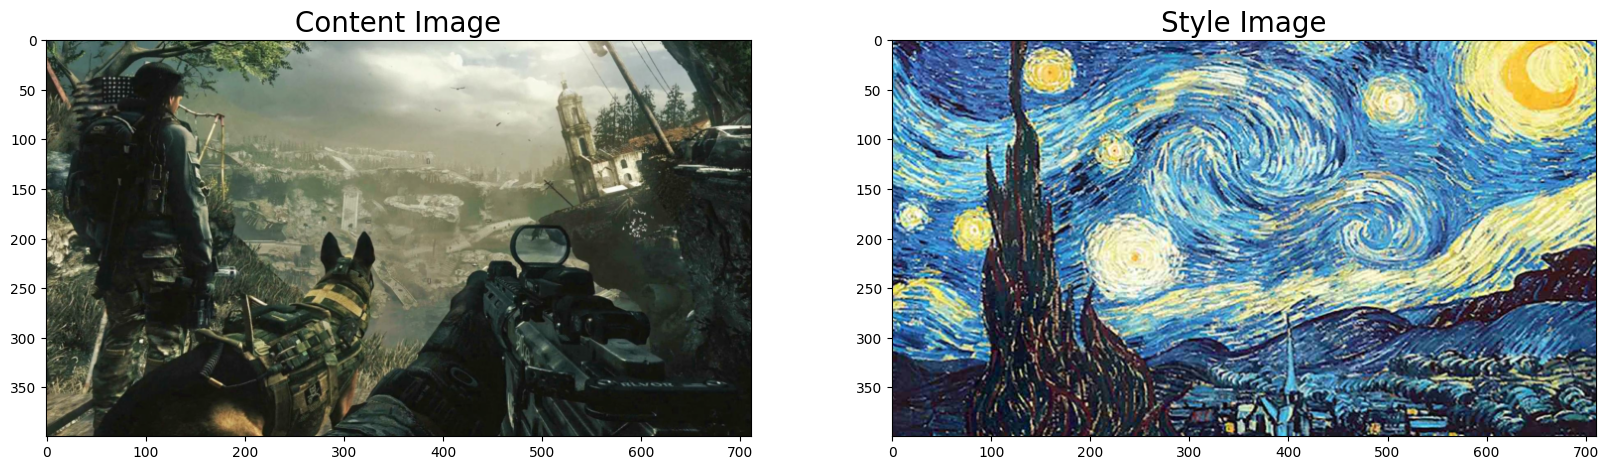

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("Content Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize = 20)
plt.show()

In [69]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

**Content and Style Features**
Below, complete the mapping of layer names to the names found in the paper for the content representation and the style representation.

In [70]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


**Gram Matrix**
The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth, d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
Reshape that tensor so that the spatial dimensions are flattened
Calculate the gram matrix by multiplying the reshaped tensor by it's transpose
Note: You can multiply two matrices using torch.mm(matrix1, matrix2).

In [71]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

**Putting it all Together**
Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [72]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [73]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

Total loss:  50139627520.0


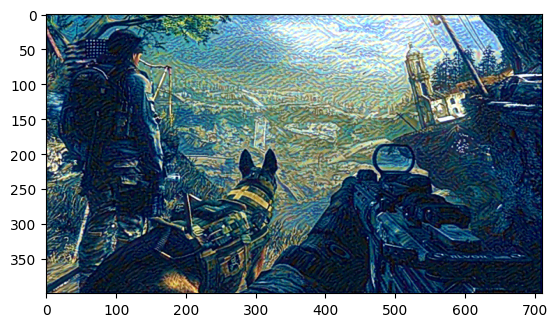

Total loss:  15691627520.0


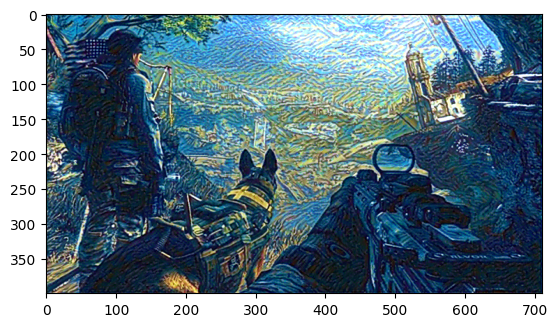

In [ ]:
# for displaying the target image, intermittently
show_every = 500

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)
loss = []
for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    loss.append(total_loss.item())

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        
        plt.imshow(im_convert(target))
        plt.show()

**LOSS plot** 

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_values):
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'bo-', label='Training loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_loss(loss)


In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Stylized Target Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)
# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()